In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from data_import import load_data, load_ecb_1y_yield
from model_dfs import prepare_merton_inputs
from merton_calibration import calibrate_merton_panel, add_physical_pd_from_implied_assets

print(Path.cwd())

c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code


In [2]:
# Load Accenture dataset
ret_daily, bs = load_data(
    xlsx_path= None,
    verbose=True
)

print(ret_daily.head())
print("-"*40)
print(bs.head())

      country_iso          isin       date                       company  \
41651         DEU  DE0005190003 2010-01-05  BAYERISCHE MOTOREN WERKE AKT   
41652         DEU  DE0005190003 2010-01-06  BAYERISCHE MOTOREN WERKE AKT   
41653         DEU  DE0005190003 2010-01-07  BAYERISCHE MOTOREN WERKE AKT   
41654         DEU  DE0005190003 2010-01-08  BAYERISCHE MOTOREN WERKE AKT   
41655         DEU  DE0005190003 2010-01-11  BAYERISCHE MOTOREN WERKE AKT   

        gvkey   shares_out   close  mcap_reported  shares_out_filled  \
41651  100022  601995196.0  32.310   1.945046e+10        601995196.0   
41652  100022  601995196.0  32.810   1.975146e+10        601995196.0   
41653  100022  601995196.0  33.100   1.992604e+10        601995196.0   
41654  100022  601995196.0  32.655   1.965815e+10        601995196.0   
41655  100022  601995196.0  32.170   1.936619e+10        601995196.0   

               mcap  bad_day  logret_close  logret_mcap  
41651  1.945046e+10    False      0.008080     0.008

In [ ]:
# Load ECB 1Y risk-free yield data

# If first time, call API to get data:
df_rf = load_ecb_1y_yield(
    startPeriod="2010-01-01",
    endPeriod="2025-12-31",
    out_file="ecb_yc_1y_aaa.xml",
    verify_ssl=False
)

#df_rf.to_csv("ecb_riskfree_1y_daily.csv", index=False)
print(df_rf.head())

c:\Users\vkeenan\AppData\Local\miniconda3\envs\Accenture\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data-api.ecb.europa.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Data has been written to ecb_yc_1y_aaa.xml
        date      r_1y
0 2010-01-04  0.008330
1 2010-01-05  0.007934
2 2010-01-06  0.007782
3 2010-01-07  0.007491
4 2010-01-08  0.007417


In [3]:
# If already saved to CSV without recalling API:
df_rf= pd.read_csv("ecb_riskfree_1y_daily.csv", parse_dates=["date"])
print(df_rf.head())

        date      r_1y
0 2010-01-04  0.008330
1 2010-01-05  0.007934
2 2010-01-06  0.007782
3 2010-01-07  0.007491
4 2010-01-08  0.007417


In [4]:
# Merton model inputs and implementation
merton_inputs = prepare_merton_inputs(ret_daily, bs, df_rf)

print(merton_inputs[["gvkey","date","E","B","r","sigma_E"]].head(20))

# Check missingness of sigma_E
print("Missing sigma_E %:", merton_inputs["sigma_E"].isna().mean() * 100)
print(merton_inputs["sigma_E"].describe())

# Check missingness of B and r
print("Missing B %:", merton_inputs["B"].isna().mean() * 100)
print("Missing r %:", merton_inputs["r"].isna().mean() * 100)

     gvkey       date             E             B         r  sigma_E
0   100022 2010-01-05  1.945046e+10  8.526755e+10  0.007934      NaN
1   100022 2010-01-06  1.975146e+10  8.526941e+10  0.007782      NaN
2   100022 2010-01-07  1.992604e+10  8.527122e+10  0.007491      NaN
3   100022 2010-01-08  1.965815e+10  8.527297e+10  0.007417      NaN
4   100022 2010-01-11  1.936619e+10  8.527817e+10  0.007056      NaN
5   100022 2010-01-12  1.880332e+10  8.527982e+10  0.007145      NaN
6   100022 2010-01-13  1.891770e+10  8.528149e+10  0.007167      NaN
7   100022 2010-01-14  1.919763e+10  8.528317e+10  0.006944      NaN
8   100022 2010-01-15  1.904111e+10  8.528479e+10  0.006620      NaN
9   100022 2010-01-18  1.932405e+10  8.528943e+10  0.006726      NaN
10  100022 2010-01-19  1.952270e+10  8.529100e+10  0.006979      NaN
11  100022 2010-01-20  1.914345e+10  8.529263e+10  0.007060      NaN
12  100022 2010-01-21  1.875516e+10  8.529428e+10  0.006933      NaN
13  100022 2010-01-22  1.848125e+1

date
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
2010-01-11    0.0
2010-01-12    0.0
2010-01-13    0.0
2010-01-14    0.0
2010-01-15    0.0
2010-01-18    0.0
Name: B, dtype: float64
date
2025-12-08    0.0
2025-12-09    0.0
2025-12-10    0.0
2025-12-11    0.0
2025-12-12    0.0
2025-12-15    0.0
2025-12-16    0.0
2025-12-17    0.0
2025-12-18    0.0
2025-12-19    0.0
Name: B, dtype: float64


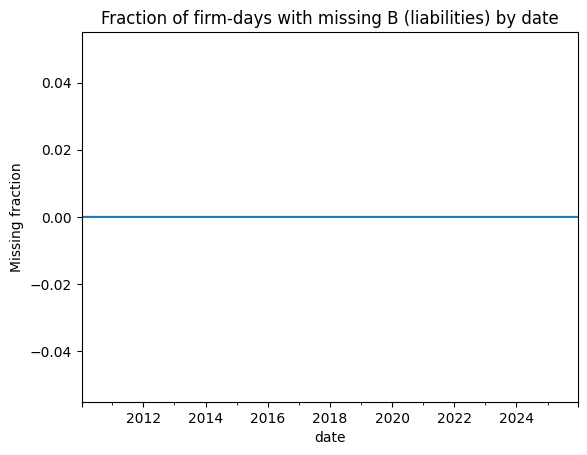

In [5]:
B_miss_by_date = merton_inputs["B"].isna().groupby(merton_inputs["date"]).mean()

print(B_miss_by_date.head(10))
print(B_miss_by_date.tail(10))

B_miss_by_date.plot()
plt.title("Fraction of firm-days with missing B (liabilities) by date")
plt.ylabel("Missing fraction")
plt.show()


In [6]:
# BUILDING THE CALIBRATION DATASET DROPPING ROWS WITH MISSING INPUTS
df = merton_inputs.copy()

# first date where B becomes available for each firm
first_B_date = (
    df.dropna(subset=["B"])
      .groupby("gvkey")["date"]
      .min()
      .rename("first_B_date")
)
# first date where sigma_E becomes available for each firm
first_sigma_date = (
    df.dropna(subset=["sigma_E"])
      .groupby("gvkey")["date"]
      .min()
      .rename("first_sigma_date")
)

starts = pd.concat([first_B_date, first_sigma_date], axis=1)
starts["calib_start"] = starts[["first_B_date","first_sigma_date"]].max(axis=1)

# attach and filter
df2 = df.merge(starts["calib_start"], on="gvkey", how="left")

calib = (
    df2[df2["date"] >= df2["calib_start"]]
      .dropna(subset=["E","B","r","sigma_E"])
      .query("E > 0 and B > 0")
      .copy()
      .rename(columns={"B":"B_drop"})
)

print("Rows before:", len(df), "Rows after firm-specific start + required inputs:", len(calib))
print("Dropped %:", (len(df)-len(calib))/len(df))
print("Missing values in calibration dataset:")
print(calib.isna().sum())

calib_drop = calib.copy()

Rows before: 198390 Rows after firm-specific start + required inputs: 192140
Dropped %: 0.03150360401229901
Missing values in calibration dataset:
gvkey            0
date             0
E                0
logret_mcap      0
isin             0
company          0
country_iso      0
r                0
B_drop           0
sigma_E_daily    0
sigma_E          0
calib_start      0
dtype: int64


In [7]:
# CALIBRATE MERTON MODEL
# Dropped missing B calibration
merton_calib = calibrate_merton_panel(
    calib_drop,
    B_col="B_drop",
    warm_start=True,
)

# physical PD via implied-asset drift
merton_calib = add_physical_pd_from_implied_assets(merton_calib)

# diagnostics
for name, df in [("dropped", merton_calib)]:
    print("\n---", name, "---")
    print("Solver success rate:", df["solver_success"].mean())
    print("V/E min:", np.nanmin(df["V"]/df["E"]), "median:", np.nanmedian(df["V"]/df["E"]))
    print("PD_rn summary:")
    print(df["PD_rn"].describe())


c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:71: RuntimeWarning: overflow encountered in exp
  sV = np.exp(z[1])
c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:18: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (log_V_B + (r + 0.5 * sigmaV**2) * T) / sig_sqrtT
c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:70: RuntimeWarning: overflow encountered in exp
  V = np.exp(z[0])
c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code\merton_calibration.py:74: RuntimeWarning: invalid value encountered in scalar multiply
  sigE_mod = Nd1 * (V / E) * sV



--- dropped ---
Solver success rate: 0.9999011137712085
V/E min: 1.0188656268452256 median: 2.168427720342175
PD_rn summary:
count     1.921210e+05
mean      5.050913e-03
std       4.810661e-02
min      3.364561e-173
25%       1.081864e-14
50%       5.327609e-09
75%       2.344012e-05
max       9.996275e-01
Name: PD_rn, dtype: float64


In [8]:
cols = [
    "gvkey", "date", "isin", "company", "country_iso",
    "E", "sigmaE", "B", "r", "T",
    "solver_success", "DD_rn", "PD_rn",
    "logV", "dlogV", "mu_V", "DD_p", "PD_p",
]
df_show = df.loc[:, [c for c in cols if c in df.columns]]
print(df_show.head(5))
print(df_show.tail(5))


    gvkey       date          isin                       company country_iso  \
0  100022 2010-06-29  DE0005190003  BAYERISCHE MOTOREN WERKE AKT         DEU   
1  100022 2010-06-30  DE0005190003  BAYERISCHE MOTOREN WERKE AKT         DEU   
2  100022 2010-07-01  DE0005190003  BAYERISCHE MOTOREN WERKE AKT         DEU   
3  100022 2010-07-02  DE0005190003  BAYERISCHE MOTOREN WERKE AKT         DEU   
4  100022 2010-07-05  DE0005190003  BAYERISCHE MOTOREN WERKE AKT         DEU   

              E         r    T  solver_success     DD_rn     PD_rn       logV  \
0  2.401961e+10  0.003801  1.0            True  3.810468  0.000069  25.419316   
1  2.411894e+10  0.004237  1.0            True  3.833748  0.000063  25.420231   
2  2.299622e+10  0.004696  1.0            True  3.738235  0.000093  25.409944   
3  2.280659e+10  0.004665  1.0            True  3.746490  0.000090  25.408205   
4  2.294204e+10  0.004468  1.0            True  3.759135  0.000085  25.409485   

      dlogV  mu_V  DD_p  PD_p  
